

In this project, data mining techniques are implemented and applied to a real-world imbalanced dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [1]:
!pip install ucimlrepo

## Imports

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import itertools, collections
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from collections import Counter
import networkx as nx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

from ucimlrepo import fetch_ucirepo

## Load Data

In [7]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [9]:
y_flat = y.values.ravel()
X_df = pd.DataFrame(X, columns=breast_cancer_wisconsin_diagnostic.feature_names)
y_df = pd.Series(y_flat, name='Diagnosis')
df = pd.concat([X_df, y_df], axis=1)


print(df)

     radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0      17.99     10.38      122.80  1001.0      0.11840       0.27760   
1      20.57     17.77      132.90  1326.0      0.08474       0.07864   
2      19.69     21.25      130.00  1203.0      0.10960       0.15990   
3      11.42     20.38       77.58   386.1      0.14250       0.28390   
4      20.29     14.34      135.10  1297.0      0.10030       0.13280   
..       ...       ...         ...     ...          ...           ...   
564    21.56     22.39      142.00  1479.0      0.11100       0.11590   
565    20.13     28.25      131.20  1261.0      0.09780       0.10340   
566    16.60     28.08      108.30   858.1      0.08455       0.10230   
567    20.60     29.33      140.10  1265.0      0.11780       0.27700   
568     7.76     24.54       47.92   181.0      0.05263       0.04362   

     concavity1  concave_points1  symmetry1  fractal_dimension1  ...  \
0       0.30010          0.14710     0.2419        

## Exploratory Data Analysis (EDA)

### Pairwise correlation between features

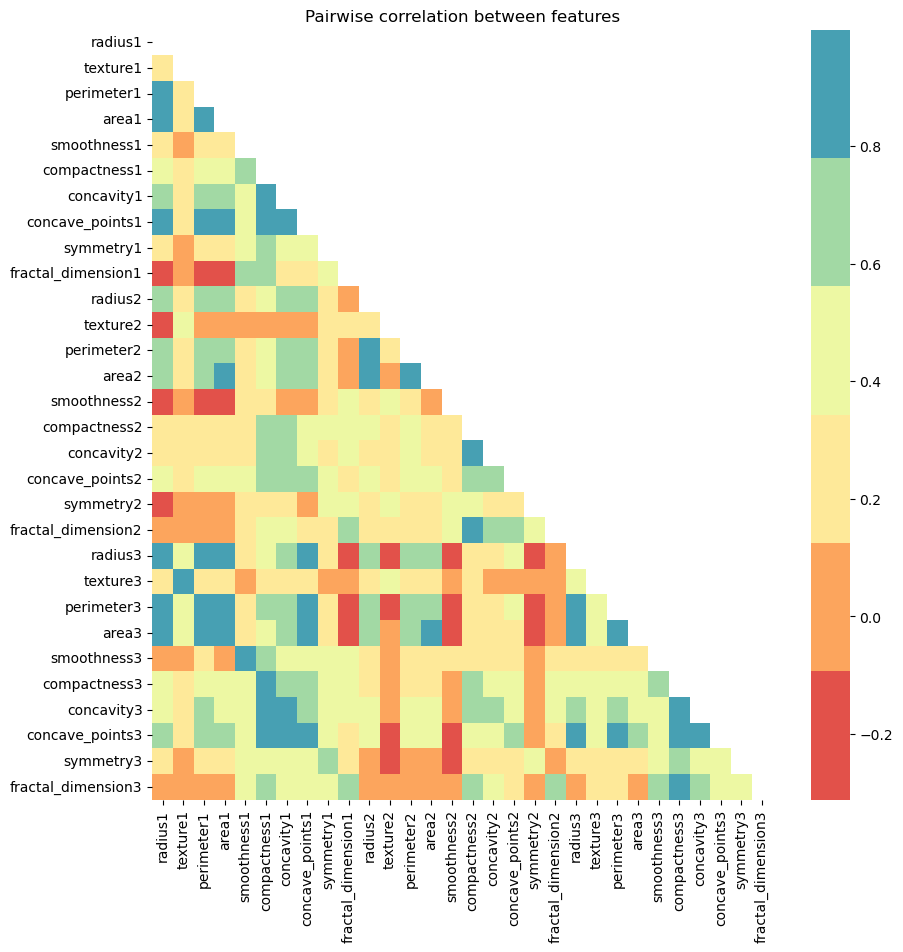

In [13]:
correlation = X.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlation, annot=False, mask=np.triu(correlation),
            cmap=sns.color_palette("Spectral"))
ax.set_title("Pairwise correlation between features")
plt.show()

### Class-wise counts

In [16]:
print(collections.Counter(y['Diagnosis']))

Counter({'B': 357, 'M': 212})


### Class-wise features distributions

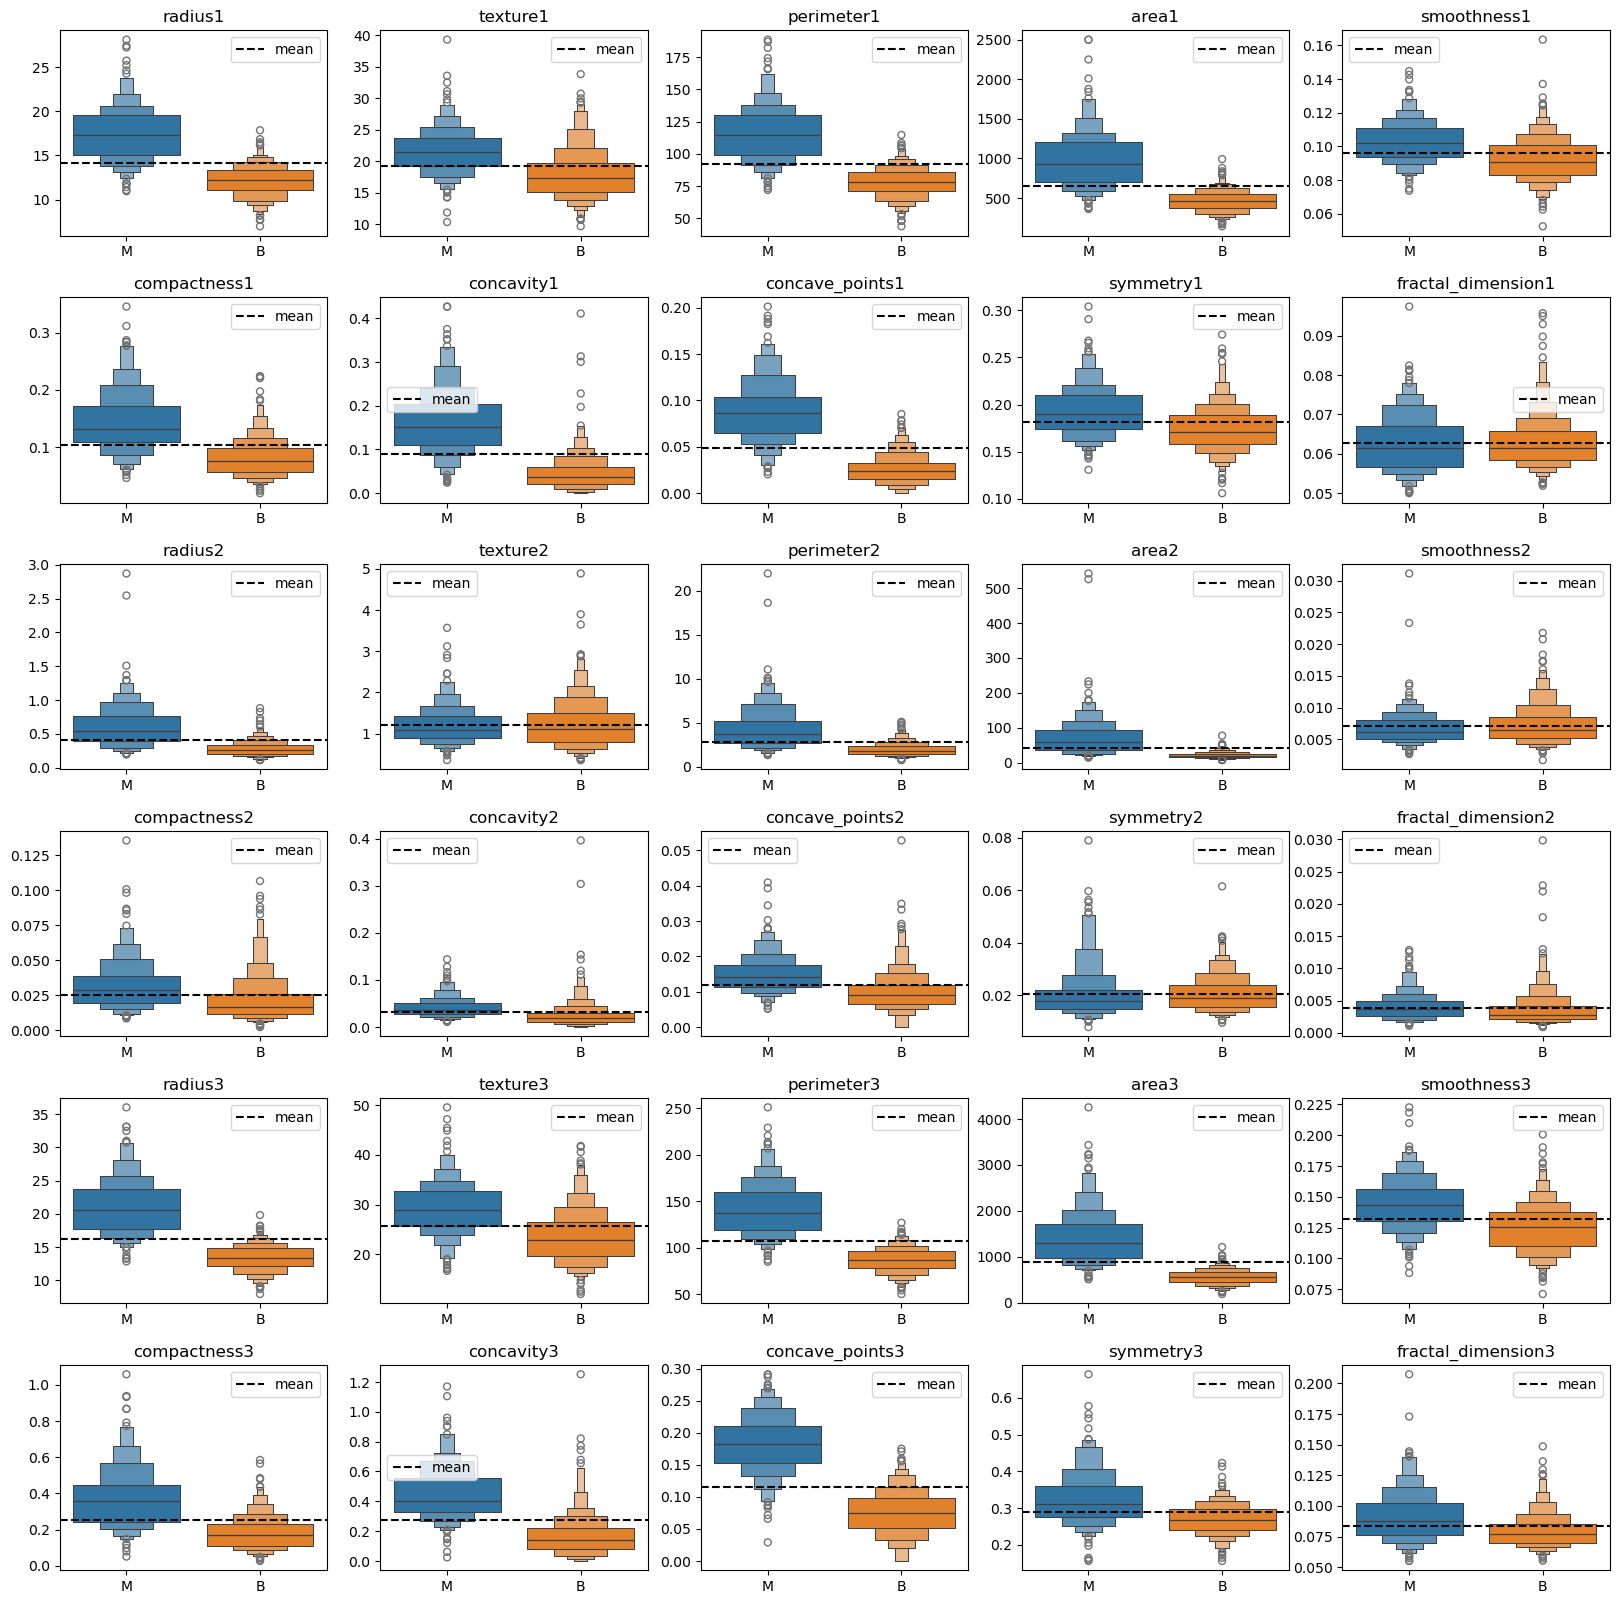

In [19]:
plt.figure(figsize=(20,20))

for i,j in itertools.zip_longest(list(X.columns), range(len(list(X.columns)))):
  plt.subplot(6,5,j+1)
  sns.boxenplot(x=y['Diagnosis'], y=X[i], hue=y['Diagnosis'])
  plt.title(i)
  plt.xlabel('')
  plt.ylabel('')
  plt.subplots_adjust(hspace=.3)
  plt.axhline(X[i].mean(), linestyle="dashed", color='k', label='mean')
  plt.legend(loc='best')

In [21]:
df_train, df_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=45)

In [23]:
target = 'Diagnosis'
features = [col for col in df.columns if col != target]
print(features)
train_data = pd.concat([df_train, y_train], axis=1)

['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']


Diagnosis
B    357
M    212
Name: count, dtype: int64


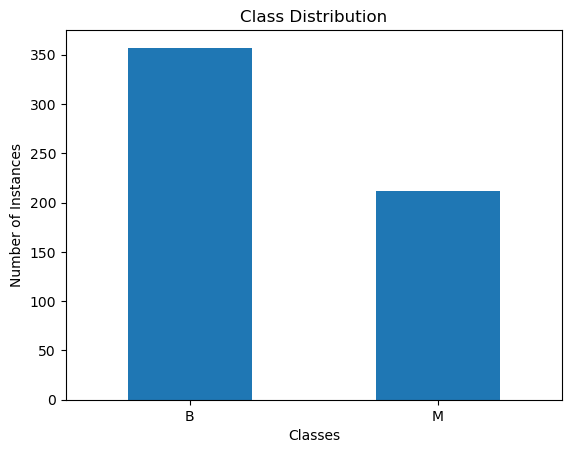

In [25]:
class_counts = df['Diagnosis'].value_counts()
print(class_counts)

class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0) 
plt.show()

In [27]:
print(df_train.columns)

Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3'],
      dtype='object')


# Supervised Techniques

## Implementing simple classifiers





<h3> Decision Tree Classifier Implementation  </h3>

In order to implement the Decision tree classifier using Information gain we followed these steps:

<b> Step 1 - Entropy Calculation : </b>
It calculates the impurity or uncertainity of the dataset, here we are calculating weighted entropy as the data set is imbalance we have 357 values for B class and 212 values for M class of target 'Diagnosis'.Hence we are trying to calculate the entropy by assigning more weight to minority class

<b> Step 2 - Information gain : </b>
This method calculated for each feature and measures how much uncertainity is reduced after splitting the dataset on a particular feature. We calculate it for each feature and the one with maximum feature is selected iteratively.Here we considered a threshold value which is the midpoint of two consecutive sorted values and we either add features to left subtree or right subtree based on the condition. Reason for using a threshold is to as the data set features with continues values

<b> Step 3 - Identifying best feature : </b>
The information gain method is called to calculate gain and threshold for every feature and updates the best info gain, best feature and best threshold variables.

<b> Step 4 - Finding the Majority class : </b>
This method assigns the leaf node with no further split with a predicted class to that node which is most frequent class among the other instances.

<b> Step 5 - Build Tree : </b>
This method builds the tree recursively, it checks 4 conditions 1) whether all instances belong to same class 2) if there are no further features to split on 3) checks if the maximum depth has been reached 4) for the remaining cases we are identifying the best feature and best threshold value from the 'identifying best feature' function. We denoted tree structure using as dictionary with best feature as key and values are dictionaries for the left and right branches.

<b> Step 6 - Predicting : </b>
We are trying to make prediction for each individual samples by traversing the decision tree recursively.The predict_single method is applied to all rows in the test_set. We check for the base condition if only a leaf is present in the tree and returns its class label. We retrieve feature and threshold values at each node.After reaching a leaf node the class label is returned.


<h4> Key features in the model implemention - </h4>



<b> Handling Class Imbalance -  </b>
Using weighted entropy enables to provide importance to the minority class , inorder to improve decision tree classification accuracy on imbalanced datasets

<b> Handling Continuous Features - </b> We are finding the optimal threshols for continous features (radius_mean, texture_mean) which allows to split the features more accurately 

<b> Determining Max-Depth - </b> By limiting the max depth of decision tree to 5 we are trying to prevent overfitting and enable model to be generalizable to new data

<b> Single Sample Prediciton - </b> Traversing the tree to predict individual samples in order to make the model suitable for real time data

<b> Majority Class Prediction at Leaf Nodes - </b> We are assigning the most common class at leaf nodes ensuring reliable predictions when no further split is possible.



In [32]:

class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def get_params(self, deep=True):
        return {"max_depth": self.max_depth}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def entropy(self, df, target, class_weights=None):
        vals, counts = np.unique(df[target], return_counts=True)
        probabilities = counts / len(df)
        if class_weights:
            weight_dict = dict(zip(vals, class_weights))
            weights = np.array([weight_dict[val] for val in vals])
            weighted_entropy = -np.sum(weights * probabilities * np.log2(probabilities))
        else:
            weighted_entropy = -np.sum(probabilities * np.log2(probabilities))
        return weighted_entropy

    def information_gain(self, df, feature, target):
        if not np.issubdtype(df[feature].dtype, np.number):
            return -1, None

        sorted_value = np.unique(df[feature])
        best_info_gain = -1
        best_threshold = None

        for i in range(1, len(sorted_value)):
            threshold = (sorted_value[i] + sorted_value[i - 1]) / 2
            subset_left = df[df[feature] <= threshold]
            subset_right = df[df[feature] > threshold]
            weighted_entropy = (
                (len(subset_left) / len(df)) * self.entropy(subset_left, target) +
                (len(subset_right) / len(df)) * self.entropy(subset_right, target)
            )

            info_gain = self.entropy(df, target) - weighted_entropy

            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_threshold = threshold

        return best_info_gain, best_threshold

    def identifying_best_feature(self, df, features, target):
        best_feature = None
        best_info_gain = -1
        best_threshold = None

        for feature in features:
            info_gain, threshold = self.information_gain(df, feature, target)
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature
                best_threshold = threshold

        return best_feature, best_threshold

    def majority_class(self, df, target):
        counts = {}
        for label in df[target]:
            counts[label] = counts.get(label, 0) + 1
        return max(counts, key=counts.get)

    def build_tree(self, df, features, target, depth=0):
        if len(np.unique(df[target])) == 1:
            return np.unique(df[target])[0]

        if len(features) == 0:
            return self.majority_class(df, target)

        if self.max_depth is not None and depth >= self.max_depth:
            return self.majority_class(df, target)

        best_feature, best_threshold = self.identifying_best_feature(df, features, target)
        tree = {best_feature: {"<= {:.3f}".format(best_threshold): {}, "> {:.3f}".format(best_threshold): {}}}

        remaining_features = [f for f in features if f != best_feature]

        subset_left = df[df[best_feature] <= best_threshold]
        subset_right = df[df[best_feature] > best_threshold]

        tree[best_feature]["<= {:.3f}".format(best_threshold)] = self.build_tree(subset_left, remaining_features, target, depth + 1)
        tree[best_feature]["> {:.3f}".format(best_threshold)] = self.build_tree(subset_right, remaining_features, target, depth + 1)

        return tree
        
    def fit(self, df_train, target):
        features = df_train.columns.tolist()
        features.remove(target)  
        self.tree = self.build_tree(df_train, features, target)


    def predict_single(self, tree, sample):
        if not isinstance(tree, dict):
            return tree

        feature = next(iter(tree))
        thresholds = list(tree[feature].keys())

        for threshold in thresholds:
            threshold_val = float(threshold.split(" ")[1])
            if "<=" in threshold and sample[feature] <= threshold_val:
                return self.predict_single(tree[feature][threshold], sample)
            elif ">" in threshold and sample[feature] > threshold_val:
                return self.predict_single(tree[feature][threshold], sample)

        return self.majority_class(df_train, target)

    def predict(self, df_test):
        return df_test.apply(lambda row: self.predict_single(self.tree, row), axis=1)

  
target = 'Diagnosis'
df_train_combined = pd.concat([df_train, y_train], axis=1)

my_classifier = DecisionTree(max_depth=5)
my_classifier.fit(df_train_combined, target)

dt_prediction = my_classifier.predict(df_test)
accuracy_dt = accuracy_score(y_test, dt_prediction)
print(f"Accuracy: {accuracy_dt}")

precision_dt = precision_score(y_test, dt_prediction, pos_label="M")
recall_dt = recall_score(y_test, dt_prediction, pos_label="M")
f1_dt = f1_score(y_test, dt_prediction, pos_label="M")

print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")

Accuracy: 0.9385964912280702
Precision: 0.9487179487179487
Recall: 0.8809523809523809
F1 Score: 0.9135802469135802


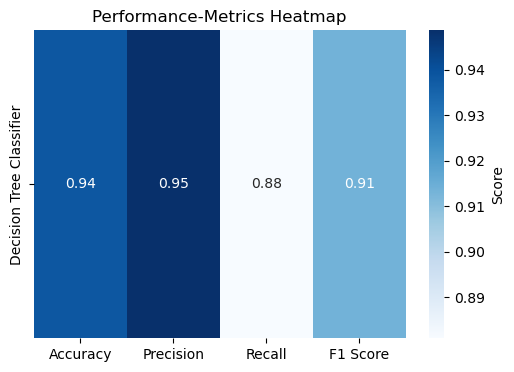

In [34]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = np.array([[accuracy_dt, precision_dt, recall_dt, f1_dt]])

plt.figure(figsize=(6, 4))
sns.heatmap(values, annot=True, cmap="Blues", xticklabels=metrics, yticklabels=["Decision Tree Classifier"], cbar_kws={'label': 'Score'})
plt.title('Performance-Metrics Heatmap')
plt.show()

<h3> Gaussian Naive Bayes Classifier Implementation -  </h3>

<h4>Implementation -  </h4>

<b>Step1 - Prioir Calculation :</b> This method calculates the prior probability for each class based on the frequency of occurence. Mean and standard deviation for each feature calculated for each feature and class.

<b>Step2 - Gaussian Probability Calculation :</b> For calculating the likelihood of a feature value belonging to a specific class

<b>Step3 - Posterior Calculation :</b> We obtain the posterior for each class by multiplying prior probability and likelihood for all the features

<b>Step4 - Prediction :</b>  For each test instance, we calculate posteriors and selects the class with the highest posterior probability.


<h4>Key features in implementation : </h4>

<b>Feature Scaling : </b>As the Gaussian Naive Bayes assumes features follow normal distribution we scaled the features using the StandardScaler.

<b>Adding Epsilon : </b>Also inorder to avoid division by zero we added an epsilon value while calculating the probabilities



In [37]:
y_flat = y.values.ravel()
X_df = pd.DataFrame(X, columns=breast_cancer_wisconsin_diagnostic.feature_names)
y_df = pd.Series(y_flat, name='Diagnosis')
df = pd.concat([X_df, y_df], axis=1)

df_train, df_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=45)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train)
X_test_scaled = scaler.transform(df_test)

class GaussianNaiveBayes:
    def __init__(self):
        self.prior_probability = None
        self.mean = {}
        self.std = {}
        self.epsilon = {}

    def get_params(self, deep=True):
        return {"epsilon": self.epsilon}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X_train, y_train, epsilon=1e-6):
        classes, class_counts = np.unique(y_train, return_counts=True)
        total_samples = len(y_train)
        self.prior_probability = {}

        for i in range(len(classes)):
            class_labels = classes[i]
            count = class_counts[i]
            prior_prob = count / total_samples
            self.prior_probability[class_labels] = prior_prob

        for c in classes:
            X_class = X_train[y_train == c]
            self.mean[c] = np.mean(X_class, axis=0)
            self.std[c] = np.std(X_class, axis=0) + epsilon

    def gaussian(self, x, mean, std):
        numerator = np.exp(-0.5 * ((x - mean) ** 2 / (std ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * std)) * numerator

    def calculating_posterior(self, X_instance):
        posteriors = {}
        for c in self.prior_probability:
            prior_probability = self.prior_probability[c]
            likelihood = 1
            for i in range(len(X_instance)):
                mean = self.mean[c][i]
                std = self.std[c][i]
                x = X_instance[i]
                likelihood *= self.gaussian(x, mean, std)
            posteriors[c] = prior_probability * likelihood
        return posteriors

    def predict_gnb(self, X_test):
        predictions_gnb = []
        for instance in X_test:
            posteriors = self.calculating_posterior(instance)
            predicted_class = max(posteriors, key=posteriors.get)
            predictions_gnb.append(predicted_class)
        return predictions_gnb

model2 = GaussianNaiveBayes()

model2.fit(X_train_scaled, y_train.values, 1e-6)

y_pred = model2.predict_gnb(X_test_scaled)

accuracy_gnb = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_gnb}")
print("Confusion Matrix:")
print(conf_matrix)
precision_gnb = precision_score(y_test, y_pred, pos_label="M")
recall_gnb = recall_score(y_test, y_pred, pos_label="M")
f1_gnb = f1_score(y_test, y_pred, pos_label="M")

print(f"Precision: {precision_gnb}")
print(f"Recall: {recall_gnb}")
print(f"F1 Score: {f1_gnb}")

Accuracy: 0.9385964912280702
Confusion Matrix:
[[70  2]
 [ 5 37]]
Precision: 0.9487179487179487
Recall: 0.8809523809523809
F1 Score: 0.9135802469135802


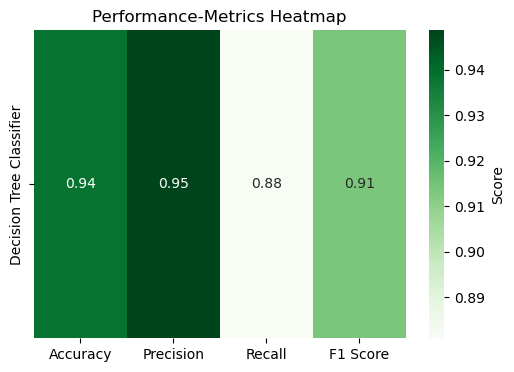

In [39]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = np.array([[accuracy_gnb, precision_gnb, recall_gnb, f1_gnb]])

plt.figure(figsize=(6, 4))
sns.heatmap(values, annot=True, cmap="Greens", xticklabels=metrics, yticklabels=["Decision Tree Classifier"], cbar_kws={'label': 'Score'})
plt.title('Performance-Metrics Heatmap')
plt.show()

## Dimensionality reduction with the Singular Value Decomposition


In order to evaluate the performance of both Decision Tree and Gaussian Naive Bayes classifier we are using SVD Singular Value Decomposition ranks for dimentionality reduction.

<b>SVD - </b> SVD decomposes the feature space, identifying singular vectors  that capture the main variations in the data. Each singular value represents the magnitude of its corresponding component, reflecting how much variance each captures.

For each chosen rank k the feature space is reduced to k dimensions, thus transforming the dataset into a simpler, lower-dimensional space while retaining the most significant information. And the model are trained on this reduced dataset.

This iterative approach helps to observe how well each classifier can learn and generalize as a function of dimensionality, with lower ranks representing more compact feature spaces and higher ranks capturing finer detail.

This evaluation helps to determine how dimensionality affects classification accuracy and reveals any patterns in the model's ability to distinguish between classes


In [44]:
# for the Decision Tree Classifier

X_df, y_df = df.drop(columns=['Diagnosis']), df['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

ranks_DT = range(1, min(X_train.shape) + 1, 8)
accuracies_DT = []

for k in ranks_DT:
    svd = TruncatedSVD(n_components=k, random_state=42)
    X_train_svd = svd.fit_transform(X_train)
    X_test_svd = svd.transform(X_test)

    df_train_svd = pd.DataFrame(X_train_svd)
    df_test_svd = pd.DataFrame(X_test_svd)

    df_train_combined = pd.concat([df_train_svd, y_train.reset_index(drop=True)], axis=1)

    features = df_train_combined.columns[:-1]
    target = df_train_combined.columns[-1]

    my_classifier_1 = DecisionTree(max_depth=5)

    my_classifier_1.fit(df_train_combined, target)

    prediction = my_classifier_1.predict(df_test_svd)

    accuracy = accuracy_score(y_test, prediction)
    accuracies_DT.append(accuracy)

    conf_matrix = confusion_matrix(y_test, prediction)
    print(f"SVD Rank: {k}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)
    print()

SVD Rank: 1
Accuracy: 94.74%
Confusion Matrix:
[[107   1]
 [  8  55]]

SVD Rank: 9
Accuracy: 92.40%
Confusion Matrix:
[[103   5]
 [  8  55]]

SVD Rank: 17
Accuracy: 92.40%
Confusion Matrix:
[[103   5]
 [  8  55]]

SVD Rank: 25
Accuracy: 92.40%
Confusion Matrix:
[[103   5]
 [  8  55]]



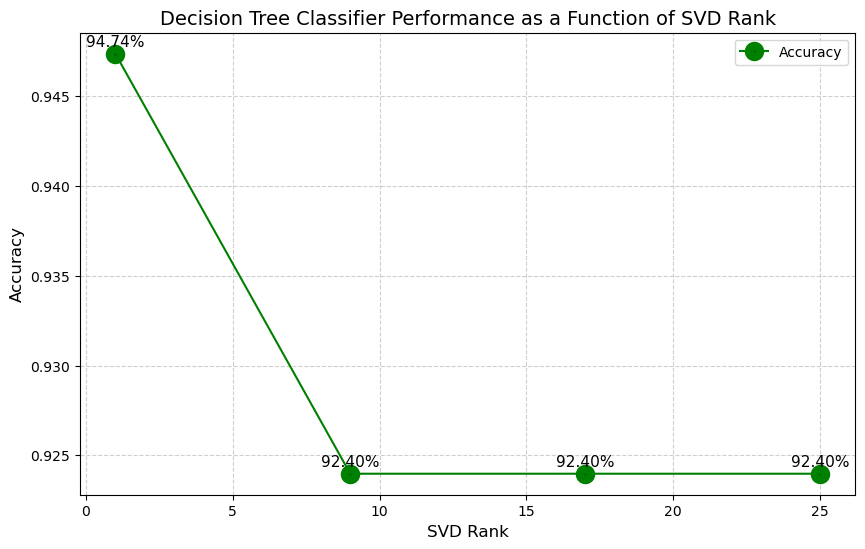

In [46]:
plt.figure(figsize=(10, 6))

plt.plot(ranks_DT, accuracies_DT, marker='o', color='g', linestyle='-', markersize=8, markerfacecolor='darkgreen', markeredgewidth=6, label='Accuracy')

plt.title('Decision Tree Classifier Performance as a Function of SVD Rank', fontsize=14)
plt.xlabel('SVD Rank', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend()

for i, txt in enumerate(accuracies_DT):
    plt.annotate(f'{txt*100:.2f}%', (ranks_DT[i], accuracies_DT[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=11, color='black')

plt.show()

In [48]:
#For Gaussian Naive Bayes Classifier

X_df, y_df = df.drop(columns=['Diagnosis']), df['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

ranks_NB = range(1, min(X_train.shape) + 1, 5)
accuracies_NB = []

for k in ranks_NB:
    svd = TruncatedSVD(n_components=k, random_state=42)
    X_train_svd = svd.fit_transform(X_train)

    X_test_svd = svd.transform(X_test)

    myclassifier_2 = GaussianNaiveBayes()
    myclassifier_2.fit(X_train_svd, y_train.values)

    y_pred = myclassifier_2.predict_gnb(X_test_svd)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies_NB.append(accuracy)

    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"SVD Rank: {k}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)
    print()

SVD Rank: 1
Accuracy: 94.15%
Confusion Matrix:
[[107   1]
 [  9  54]]

SVD Rank: 6
Accuracy: 93.57%
Confusion Matrix:
[[107   1]
 [ 10  53]]

SVD Rank: 11
Accuracy: 91.81%
Confusion Matrix:
[[102   6]
 [  8  55]]

SVD Rank: 16
Accuracy: 89.47%
Confusion Matrix:
[[100   8]
 [ 10  53]]

SVD Rank: 21
Accuracy: 90.06%
Confusion Matrix:
[[99  9]
 [ 8 55]]

SVD Rank: 26
Accuracy: 90.64%
Confusion Matrix:
[[99  9]
 [ 7 56]]



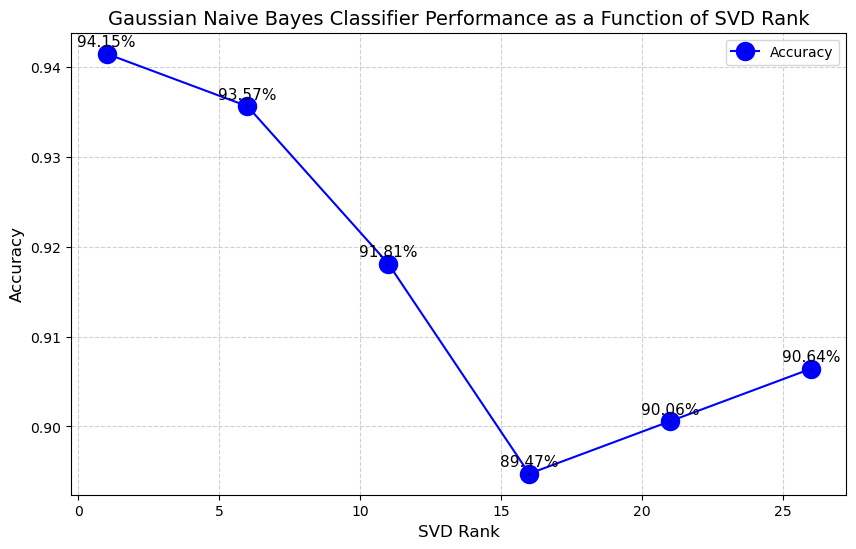

In [50]:
plt.figure(figsize=(10, 6))

plt.plot(ranks_NB, accuracies_NB, marker='o', color='b', linestyle='-', markersize=8, markerfacecolor='darkblue', markeredgewidth=6, label='Accuracy')

plt.title('Gaussian Naive Bayes Classifier Performance as a Function of SVD Rank', fontsize=14)
plt.xlabel('SVD Rank', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend()

for i, txt in enumerate(accuracies_NB):
    plt.annotate(f'{txt*100:.2f}%', (ranks_NB[i], accuracies_NB[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=11, color='black')

plt.show()


## Feature selection with randomization

_Shuffling and Randomizing Feature Columns:_
   
For each feature, the shuffling_featurecol function creates a modified copy of the dataset where only that feature’s values are shuffled.

_Evaluating Feature Impact:_
   
We use the feature_impact_calc function for the Decision Tree model and feature_impact_calc_gnb for the Naive Bayes model.
We compute the model's F1 score on the original dataset. We shuffle one feature, and then compute the F1 score again.
The performance drop (original F1 score minus shuffled F1 score) indicates the feature's importance.

_Ranking Features by Importance:_
   
The ranking_features function ranks the features in descending order based on the drop in F1 score. This helps us identify which features have the most impact on model predictions.

_Data Splits for Feature Selection and Model Evaluation:_
   
The data is first split into X_train (20%) and X_holdout (80%) for feature selection and final model evaluation, respectively.
The X_train subset is further split into X_fs (16% of original) and X_eval (4% of original) for calculating feature importance and training the model. The large X_holdout (80%) remains reserved for final evaluation.

_Model Training and Evaluation:_
   
The custom DecisionTree classifier is trained on the X_fs subset, which was used for feature importance calculation. The custom GaussianNaiveBayes classifier is similarly trained on the same data subset.

_Plotting Feature Importance:_
   
After ranking the features, we visualize the importance scores using bar charts for each model..

In [53]:

def shuffling_featurecol(df, feature):
    shuffled_df = df.copy()
    shuffled_df[feature] = np.random.permutation(shuffled_df[feature])
    return shuffled_df


def feature_impact_calc(classifier, X_eval, y_eval, target):
    original_f1 = f1_score(y_eval, classifier.predict(X_eval), pos_label="M")
    impact_scores = {}
    
    for feature in X_eval.columns:
        if feature == target:
            continue
            
        shuffled_df = shuffling_featurecol(X_eval, feature)
        shuffled_f1 = f1_score(y_eval, classifier.predict(shuffled_df), pos_label="M")
        
        
        impact_scores[feature] = original_f1 - shuffled_f1
    
    return impact_scores

def feature_impact_calc_gnb(classifier, X_eval, y_eval, target):

    if hasattr(classifier, 'predict_gnb'):
        original_f1 = f1_score(y_eval, classifier.predict_gnb(X_eval.values), pos_label="M")
    else:
        original_f1 = f1_score(y_eval, classifier.predict(X_eval), pos_label="M")
    
    impact_scores = {}
    
    for feature in X_eval.columns:
        if feature == target:
            continue
            
        shuffled_df = shuffling_featurecol(X_eval, feature)
        if hasattr(classifier, 'predict_gnb'):
            shuffled_f1 = f1_score(y_eval, classifier.predict_gnb(shuffled_df.values), pos_label="M")
        else:
            shuffled_f1 = f1_score(y_eval, classifier.predict(shuffled_df), pos_label="M")
        
        impact_scores[feature] = original_f1 - shuffled_f1
    
    return impact_scores


def ranking_features(impact_scores):
    return sorted(impact_scores.items(), key=lambda x: x[1], reverse=True)

target = 'Diagnosis'
X = df.drop(columns=[target])
y = df[target]


X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)
X_fs, X_eval, y_fs, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


my_classifier = DecisionTree(max_depth=5)
my_classifier.fit(pd.concat([X_fs, y_fs], axis=1), target)


impact_scores = feature_impact_calc(my_classifier, X_fs, y_fs, target)

ranked_features = ranking_features(impact_scores)


features, importance_scores = zip(*ranked_features)


model2 = GaussianNaiveBayes()
model2.fit(X_fs.values, y_fs.values, epsilon=1e-6)


impact_scores_nb = feature_impact_calc_gnb(model2, X_fs, y_fs, target)

ranked_features_nb = ranking_features(impact_scores_nb)

features_nb, importance_scores_nb = zip(*ranked_features_nb)


dt_prediction_holdout = my_classifier.predict(pd.concat([X_eval, y_eval], axis=1))
f1_dt_holdout = f1_score(y_eval, dt_prediction_holdout, pos_label="M")

nb_prediction_holdout = model2.predict_gnb(X_eval.values)
f1_nb_holdout = f1_score(y_eval, nb_prediction_holdout, pos_label="M")

print(f"F1 Score for Decision Tree : {f1_dt_holdout}")
print(f"F1 Score for Naive Bayesian Classifier : {f1_nb_holdout}")


F1 Score for Decision Tree : 0.9411764705882353
F1 Score for Naive Bayesian Classifier : 1.0


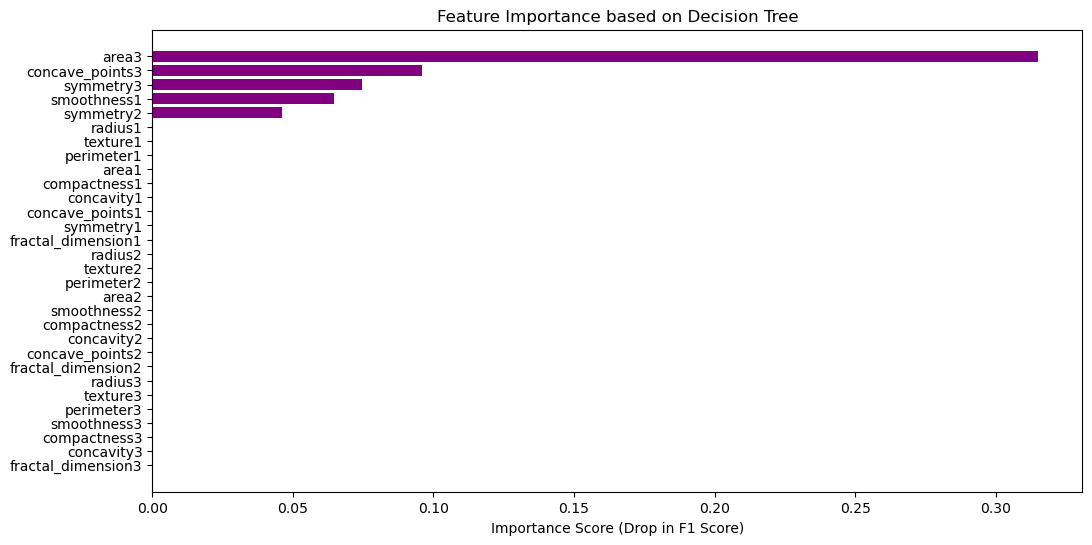

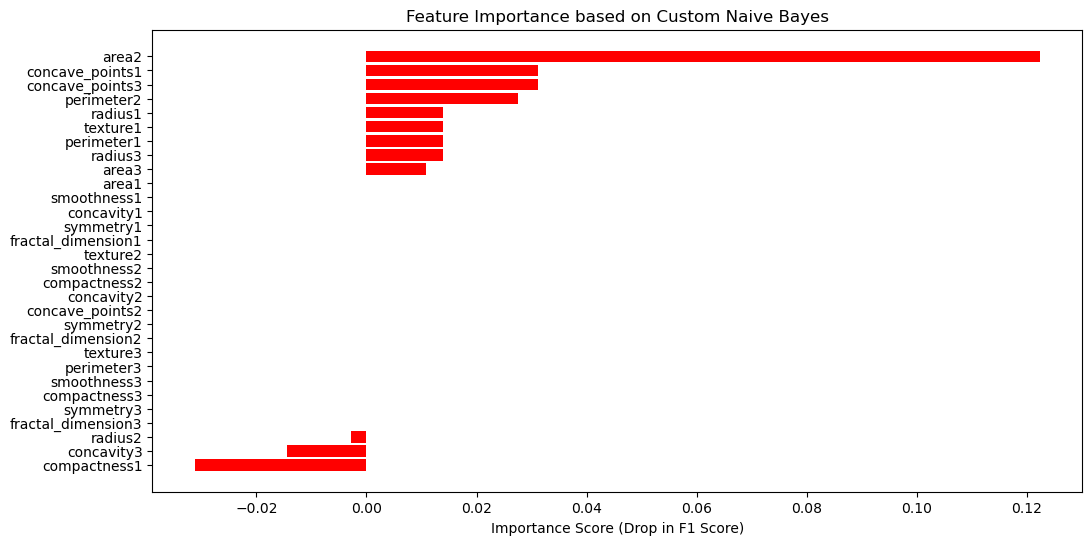

In [54]:

plt.figure(figsize=(12, 6))
plt.barh(features, importance_scores, color='purple')
plt.xlabel('Importance Score (Drop in F1 Score)')
plt.title('Feature Importance based on Decision Tree')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(features_nb, importance_scores_nb, color='red')
plt.xlabel('Importance Score (Drop in F1 Score)')
plt.title('Feature Importance based on Custom Naive Bayes')
plt.gca().invert_yaxis()
plt.show()


## Data augmentation using SMOTE


*SMOTE Implementation:*

The smote function generates synthetic samples for the minority class. This is done by finding the nearest neighbors of each sample in the minority class and interpolating between them to create new, synthetic samples.

1.   X and y: Feature matrix and target labels.

2.   minority_class: The label of the minority class that we want to oversample.

3.   k_neighbors: Number of nearest neighbors to consider when generating synthetic samples.

4.   sampling_ratio: The ratio by which we want to oversample the minority class.

*Classifier Training and Prediction:*

SMOTE is applied with different sampling ratios (100%, 200%, 300%) and k_neighbors values (1 and 5).
For each combination of sampling ratio and k_neighbors, SMOTE generates a new dataset (X_aug, y_aug), balancing the minority class with synthetic samples.

The classifiers are trained on the oversampled data (X_aug, y_aug) and evaluated on a test set (X_test, y_test).

*Metrics Calculation:*

The evaluation metrics Accuracy, Precision, Recall, and F1 Score are computed for the "M" class. These metrics are stored in the results dictionary for each sampling ratio and k value.

*F1 Score Plotting:*

We plot the F1 scores for different oversampling ratios and values of k to observe how SMOTE affects the performance of the classifiers (Decision Tree and Naive Bayes).

In [58]:

def smote(X, y, minority_class, sampling_ratio=1.0, k_neighbors=5):
    
    X_min = X[y == minority_class]
    n_min = len(X_min)
    n_synthetic = int(sampling_ratio * n_min)

    knn = NearestNeighbors(n_neighbors=k_neighbors + 1)
    knn.fit(X_min)
    neighbors = knn.kneighbors(X_min, return_distance=False)[:, 1:]

    synthetic_samples = []
    for i in range(n_synthetic):
        sample_idx = np.random.randint(0, n_min)
        neighbor_idx = np.random.choice(neighbors[sample_idx])
        diff = X_min.iloc[neighbor_idx] - X_min.iloc[sample_idx]
        synthetic_sample = X_min.iloc[sample_idx] + np.random.rand() * diff
        synthetic_samples.append(synthetic_sample)

    X_synthetic = pd.DataFrame(synthetic_samples, columns=X.columns)
    y_synthetic = pd.Series([minority_class] * n_synthetic, name=y.name)

    X_aug = pd.concat([X, X_synthetic], axis=0).reset_index(drop=True)
    y_aug = pd.concat([y, y_synthetic], axis=0).reset_index(drop=True)

    return X_aug, y_aug

sampling_ratios = [1.0, 2.0, 3.0]
k_values = [1, 5]
classifiers = {'Decision Tree': DecisionTree(max_depth=5), 'Naive Bayes': GaussianNaiveBayes()}
results = {'Classifier': [], 'Sampling Ratio': [], 'k': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for val in sampling_ratios:
    for k in k_values:
        print(f"\nTesting with sampling ratio = {val*100}%, k = {k}")

        X_aug, y_aug = smote(X_train, y_train, minority_class="M", sampling_ratio=val, k_neighbors=k)

        for name, classifier in classifiers.items():
            if name == 'Decision Tree':
                df_train_aug = pd.concat([X_aug, y_aug], axis=1)
                classifier.fit(df_train_aug, target)
                predictions = classifier.predict(X_test)
            else:
                classifier.fit(X_aug.values, y_aug.values)
                predictions = classifier.predict_gnb(X_test.values)

            accuracy = accuracy_score(y_test, predictions)
            precision = precision_score(y_test, predictions, pos_label="M")
            recall = recall_score(y_test, predictions, pos_label="M")
            f1 = f1_score(y_test, predictions, pos_label="M")

            results['Classifier'].append(name)
            results['Sampling Ratio'].append(val * 100)
            results['k'].append(k)
            results['Accuracy'].append(accuracy)
            results['Precision'].append(precision)
            results['Recall'].append(recall)
            results['F1 Score'].append(f1)

            print(f"{name} - Sampling Ratio {val*100}%, k = {k}:")
            print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")



Testing with sampling ratio = 100.0%, k = 1
Decision Tree - Sampling Ratio 100.0%, k = 1:
Accuracy: 0.9532163742690059, Precision: 0.9508196721311475, Recall: 0.9206349206349206, F1 Score: 0.9354838709677419
Naive Bayes - Sampling Ratio 100.0%, k = 1:
Accuracy: 0.9532163742690059, Precision: 0.9661016949152542, Recall: 0.9047619047619048, F1 Score: 0.9344262295081968

Testing with sampling ratio = 100.0%, k = 5
Decision Tree - Sampling Ratio 100.0%, k = 5:
Accuracy: 0.8713450292397661, Precision: 0.7887323943661971, Recall: 0.8888888888888888, F1 Score: 0.835820895522388
Naive Bayes - Sampling Ratio 100.0%, k = 5:
Accuracy: 0.9415204678362573, Precision: 0.9649122807017544, Recall: 0.873015873015873, F1 Score: 0.9166666666666666

Testing with sampling ratio = 200.0%, k = 1
Decision Tree - Sampling Ratio 200.0%, k = 1:
Accuracy: 0.9649122807017544, Precision: 0.9384615384615385, Recall: 0.9682539682539683, F1 Score: 0.953125
Naive Bayes - Sampling Ratio 200.0%, k = 1:
Accuracy: 0.95321

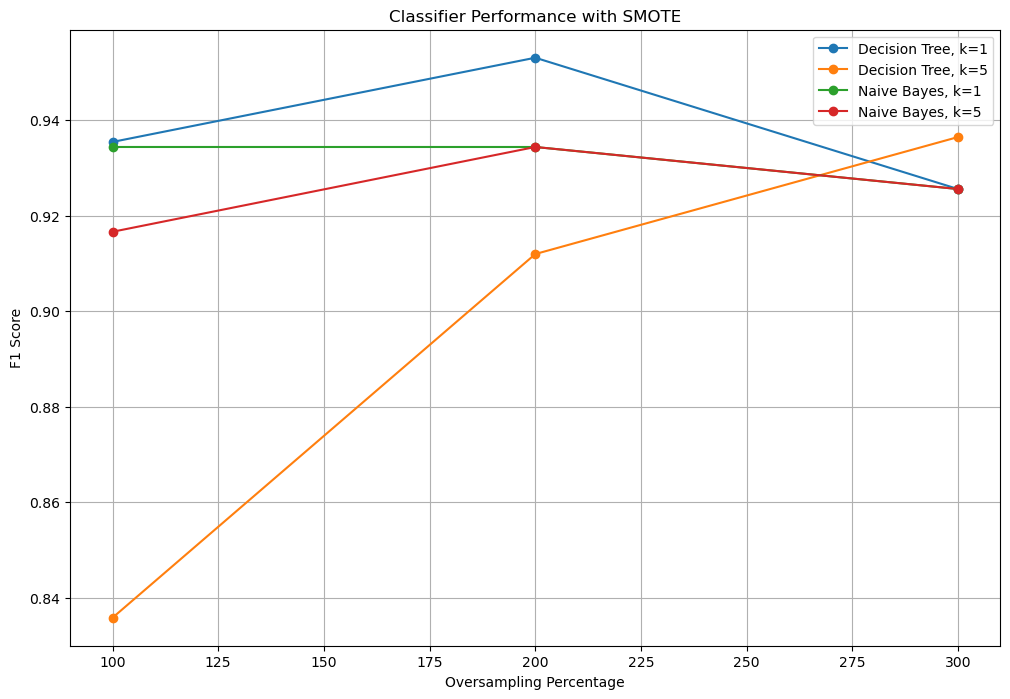

In [59]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 8))

for name in classifiers.keys():
    for k in k_values:
        subset = results_df[(results_df['Classifier'] == name) & (results_df['k'] == k)]
        plt.plot(subset['Sampling Ratio'], subset['F1 Score'], marker='o', label=f"{name}, k={k}")

plt.title('Classifier Performance with SMOTE')
plt.xlabel('Oversampling Percentage')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

# References / Disclosures

Research Papers :

- Sathiyanarayanan, P., Pavithra, S., Saranya, M. S., & Makeswari, M. (2019). Identification of breast cancer using the Decision Tree algorithm. 2019     IEEE International Conference on System, Computation, Automation and Networking (ICSCAN). https://doi.org/10.1109/icscan.2019.8878757

- Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial         Intelligence Research, 16, 321–357.

- Jaradat, Y., Masoud, M., Jannoud, I., Manasrah, A., & Alia, M. (2021). A tutorial on singular value decomposition with applications on image        
  compression and dimensionality reduction. International Conference on Information Technology. https://doi.org/10.1109/icit52682.2021.9491732




Websites :

- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e

- https://towardsdatascience.com/gaussian-naive-bayes-explained-a-visual-guide-with-code-examples-for-beginners-04949cef383c

- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.htm






